In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

# Load the dataset
df = pd.read_csv('manualannoated_datset_final.csv', encoding='latin1')

# Preprocessing the text data
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define a function to clean the text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Handle missing or unexpected values in the 'My_Labels' column
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
df = df[df['category'].isin(y_dict.keys())]

# Apply the clean_text function to the text column
df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

# Split the dataset into X and y after cleaning and filtering
X = df['Base_Reviews'].values
y = [y_dict[item] for item in df['category'].values]

# Convert the labels to categorical variables
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)

# Tokenize the data
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Pad the sequences
maxlen = 100
X = pad_sequences(X, maxlen=maxlen)

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Define the RNN model
rnn_model = keras.models.Sequential()
rnn_model.add(keras.layers.Embedding(max_features, 128, input_length=maxlen))
rnn_model.add(keras.layers.SimpleRNN(128, dropout=0.4, recurrent_dropout=0.4))
rnn_model.add(keras.layers.Dense(64, activation='relu'))
rnn_model.add(keras.layers.Dense(num_classes, activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
rnn_model.summary()

# Perform k-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
rnn_acc_scores = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    rnn_loss, rnn_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
    rnn_acc_scores.append(rnn_acc)

avg_rnn_acc = np.mean(rnn_acc_scores)
print("RNN: Average Accuracy = {:.2f}".format(avg_rnn_acc))




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          256000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 297672 (1.14 MB)
Trainable params: 297672 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
RNN: Average Accuracy = 0.74


In [2]:
# Confusion Matrix
rnn_pred = np.argmax(rnn_model.predict(X_test), axis=-1)
rnn_cm = confusion_matrix(np.argmax(y_test, axis=-1), rnn_pred)



77/77 [==============================] - 1s 5ms/step


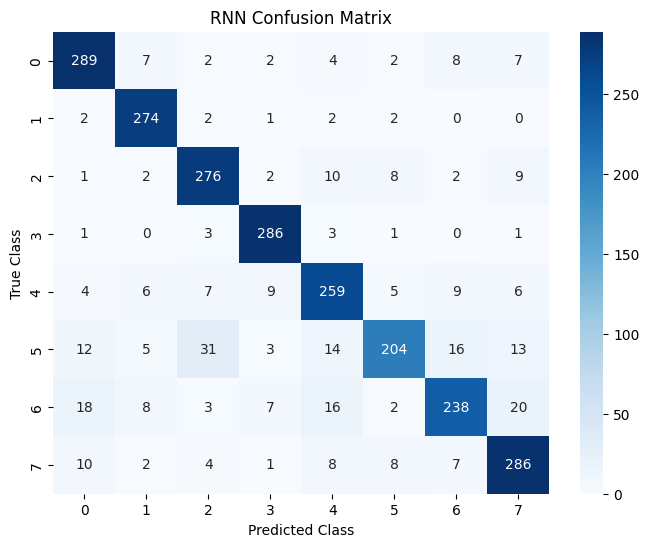

In [3]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()



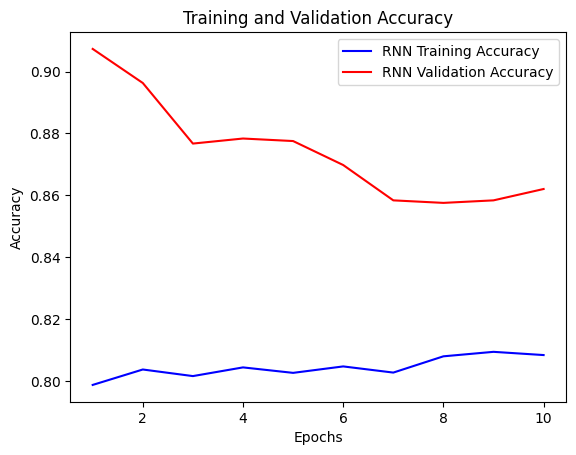

In [4]:
# Accuracy Graph
epochs = range(1, len(rnn_history.history['accuracy']) + 1)
plt.plot(epochs, rnn_history.history['accuracy'], 'b', label='RNN Training Accuracy')
plt.plot(epochs, rnn_history.history['val_accuracy'], 'r', label='RNN Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [5]:

# Calculate precision, recall, and F1-score for RNN
rnn_pred = np.argmax(rnn_model.predict(X_test), axis=-1)
rnn_report = classification_report(np.argmax(y_test, axis=-1), rnn_pred)
print("RNN Classification Report:")
print(rnn_report)

77/77 [==============================] - 0s 5ms/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       321
           1       0.90      0.97      0.93       283
           2       0.84      0.89      0.87       310
           3       0.92      0.97      0.94       295
           4       0.82      0.85      0.83       305
           5       0.88      0.68      0.77       298
           6       0.85      0.76      0.80       312
           7       0.84      0.88      0.86       326

    accuracy                           0.86      2450
   macro avg       0.86      0.86      0.86      2450
weighted avg       0.86      0.86      0.86      2450

